# Titanic

### Abstract

This is a simple analysis of the Titanic dataset, which has the known details of the passengers of the Titanic and whether or not the passenger survived the sinking. After some discussion about the descriptive variables and some light feature engineering, a number of classification models were fitted to the training data and then evaluated. Finally for comparison, a neural network was fitted to the training data using Keras. With boolean variables for the port of embarkment, class of travel, sex and whether or not an individual was travelling alone, the descriptive variables numbered at 12. The models floated around the 80% accuracy mark, with the highest performing being the bagged tree at 83%, which also had the highest f1 score (a balance of precision and recall).

In [4]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

print(keras.__version__)
plt.style.use("ggplot")


2.2.0


/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
df = pd.read_csv("../data/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df["Age"].fillna(np.mean(df["Age"]),inplace=True)

### Transformations

Here are the various functions which will later be applied.

In [8]:
def split(mydata,test_ratio=0.7):
    n = len(mydata)
    shuffled_i = np.random.permutation(n)
    test_no = int(n*test_ratio)
    test_indices = shuffled_i[:test_no]
    train_indices = shuffled_i[test_no:]
    return(mydata.iloc[test_indices],mydata.iloc[train_indices])

In [9]:
def isKid(mydata,age=5):
    mydata["IsKid"] = [1 if x <= age else 0 for x in mydata["Age"]]
    return(mydata)

In [10]:
def dummy(mydata,col,values):
    for i in values:
        mydata[str(i)] = [1 if x == i else 0 for x in mydata[col]]
    return(mydata)

In [11]:
def isAlone(mydata):
    mydata["Alone"] = [1 if mydata["SibSp"][x] == 0 and mydata["Parch"][x] == 0 else 0 for x in range(len(mydata))]
    return(mydata)

In [12]:
def segmentAge(mydata):
    mydata["AgeSeg"] = [round(int(x),-1) for x in mydata["Age"]]
    return(mydata)


In [62]:
def fareNan(mydata):
    mydata["Fare"].fillna(np.mean(mydata["Fare"]),inplace=True)
    return mydata

In [13]:
def nameLength(mydata):
    mydata["Name Length"] = [len(x.split("(")[1]) if "(" in x else len(x) for x in mydata["Name"]]
    return(mydata)

In [14]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [15]:
def scaleData(mydata,col):
    mydata[col] /= mydata[col].max()
    return(mydata)



In [112]:
# establish boolean names

x_bools = list([1,2,3,"Fare low","male","female","Alone","IsKid"])


def applyTransformations(df):
    # replace NaNs in age

    df["Age"].fillna(np.mean(df["Age"]),inplace=True)

    # supplementary variables

    # if no fare is listed, substitute with average
    
    # in case we are given anything apart from numbers
    df["Fare"] = df["Fare"].apply(pd.to_numeric)
    
    df["Fare"].fillna(np.mean(df["Fare"]),inplace=True)

    # create dummies

    df = dummy(df,"Embarked",list(df["Embarked"].unique()))
    df = dummy(df,"Sex",list(df["Sex"].unique()))
    df = dummy(df,"Pclass",list(df["Pclass"].unique()))
    df = isKid(df,5)
    df = isAlone(df)
    
    # scale relevant columns

    df = scaleData(df,"Age")
    df = scaleData(df,"Fare")

    
    return df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null object
Age               891 non-null float64
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null float64
Cabin             204 non-null object
Embarked          889 non-null object
Fare segmented    891 non-null float64
Fare low          891 non-null int64
S                 891 non-null int64
C                 891 non-null int64
Q                 891 non-null int64
nan               891 non-null int64
male              891 non-null int64
female            891 non-null int64
3                 891 non-null int64
1                 891 non-null int64
2                 891 non-null int64
IsKid             891 non-null in

In [23]:
df = applyTransformations(df)

In [19]:
#x_bool_complete = [x for x in df.columns if x not in non_bools]

In [24]:
df["Fare segmented"] = [round(x,1) for x in df["Fare"]]
df["Fare low"] = [0 if x < 0.1 else 1 for x in df["Fare segmented"]]

In [25]:
test, train = split(df,test_ratio=0.4)

## Data insight

The collection of graphs below show how the relationship between an attribute and the likelihood of survival.

### Alone-ness

First off is "alone-ness". The raw dataset features 2 parameters, "Parch" and "SibSp", which denote the number of parents and/or children and the number of siblings and/or spouses the passenger had onboard, respectively.

#### Parents/Children

The first graph on the left shows the number of parents and/or children against the number of survivals. 

#### Siblings/Spouses

Here, "SibSp" denotes the number of siblings or spouses a passenger had with them. As with the "Parch" column, being alone on the Titanic yielded a much lower probability of survival.

#### Combining this...

The graph below shows an engineered binary feature, which is __true__ if the passenger has a value of 0 for both "Sibsp" and "Parch" and ___false___ if they have someone with them. As we can see, passengers who are alone have a much lower probabilit of surviving the titanic than those with at least one person with them.

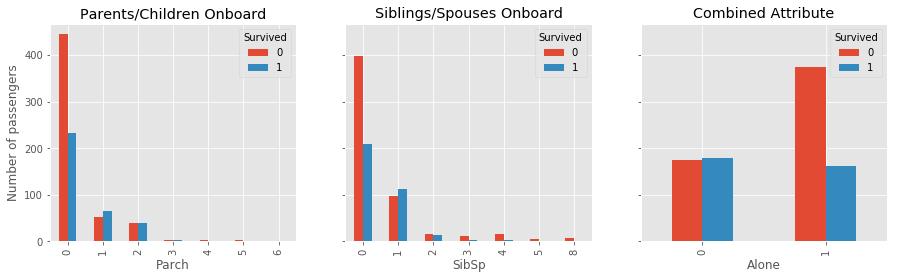

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=3,sharey="row",figsize=(15,4))
pd.crosstab(df["Parch"],df["Survived"]).plot(kind='bar',ax=ax[0],title="Parents/Children Onboard")
pd.crosstab(df["SibSp"],df["Survived"]).plot(kind='bar',ax=ax[1],title="Siblings/Spouses Onboard")
pd.crosstab(df["Alone"],df["Survived"]).plot(kind='bar',ax=ax[2],title="Combined Attribute")
ax[0].set_ylabel("Number of passengers")
plt.show()

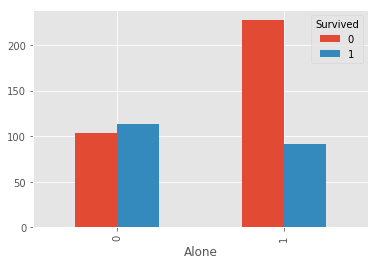

In [27]:
pd.crosstab(train["Alone"],train["Survived"]).plot(kind='bar')

### Under 5 Years of Age

This graphs shows another custom feature, which is ___true___ if the passenger is less than 5 and ___false___ if the passenger is older. As we can see here, this feature doesn't really add any value to our model, as the distribution of survivors and non-survivors is quite similar in both cases.

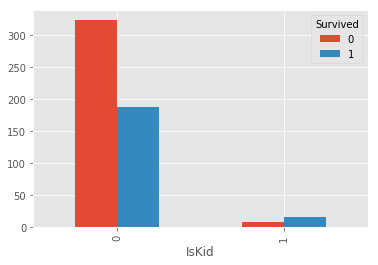

In [28]:
pd.crosstab(train["IsKid"],train["Survived"]).plot(kind='bar')

### Embarked / Passenger Class

The Titanic collected passengers at three different ports before setting across the Atlantic, the highest concentration being at Southampton. Initially, it would appear as though the passengers who boarded in Cherbourg had a higher chance of survival, but a closer look indicates that this is more likely to be a spurious relationship, as majority of the passengers who boarded in Cherbourg were 1st class passengers, who themselves had a much higher chance of surviving the Titanic when compared to the other two classes. Nevertheless, the "Embarkment" variable will be included in the final model to give extra dimensionality.

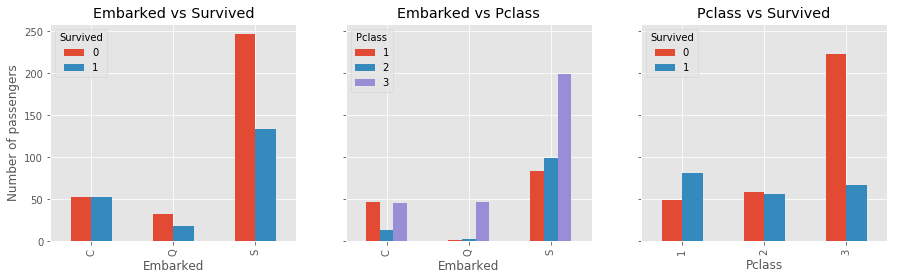

In [29]:
fig, ax = plt.subplots(nrows=1,ncols=3,sharey="row",figsize=(15,4))

pd.crosstab(train["Embarked"],train["Survived"]).plot(kind='bar',ax=ax[0],title="Embarked vs Survived")
pd.crosstab(train["Embarked"],train["Pclass"]).plot(kind='bar',ax=ax[1],title="Embarked vs Pclass")
pd.crosstab(train["Pclass"],train["Survived"]).plot(kind='bar',ax=ax[2],title="Pclass vs Survived")
ax[0].set_ylabel("Number of passengers")
plt.show()


### Age and it's relation to class and survival

Lastly, before assembling the model, I looked at the distribution of Age in relation to both class and survival.

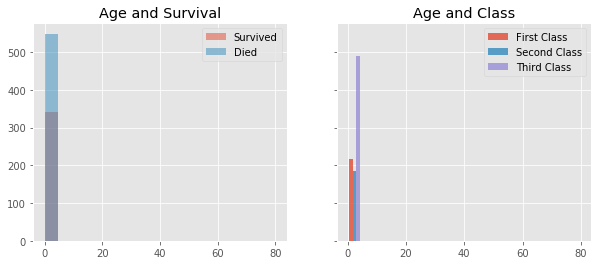

In [30]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey="row",figsize=(10,4))

# Age and survival
#df.dropna(inplace=True)
#print(np.linspace(0,80,9))
ax[0].hist(df.loc[(df["Survived"]==1)&(df["Age"]!=np.mean(df["Age"])),"Age"].values,np.linspace(0,80,18),label="Survived",alpha=0.5)
ax[0].hist(df.loc[(df["Survived"]==0)&(df["Age"]!=np.mean(df["Age"])),"Age"].values,np.linspace(0,80,18),label="Died",alpha=0.5)
ax[0].legend(loc="upper right")
ax[0].set_title(label="Age and Survival")
#plt.show()

# Age and Pclass

data = [df.loc[(df["Pclass"]==1) & (df["Age"] != np.mean(df["Age"])),"Age"].values,df.loc[(df["Pclass"]==2) & (df["Age"] != np.mean(df["Age"])),"Age"].values,df.loc[(df["Pclass"]==3) & (df["Age"] != np.mean(df["Age"])),"Age"].values]
bins = np.linspace(0,80,18)
ax[1].hist(data,bins,alpha=0.8,label=["First Class","Second Class","Third Class"])
ax[1].legend(loc="upper right")
ax[1].set_title(label="Age and Class")
plt.show()

In [ ]:
#### start of modelling

In [ ]:
df = applyTransformations(df)

In [31]:
test, train = split(df,test_ratio=0.4)

In [32]:
# define variable columns

y = ["Survived"]
x_bool_complete = ["1","2","3","Q","S","C","Age","male","female","IsKid","Alone","Fare"]


kfold = model_selection.KFold(n_splits=10,random_state=7)
scoring = 'accuracy'
num_trees = 100

train_data = train[x_bool_complete]
labels = np.array(train[y]).astype(int).ravel()

# Logistic Regression

modelCV = LogisticRegression()
logreg_results = model_selection.cross_val_score(modelCV,train_data,labels,cv=kfold,scoring=scoring)
#print("10-fold cross val accuracy: ",logreg1_results)


# Decision Tree

dt = tree.DecisionTreeClassifier(criterion='gini',max_depth=8)
dt_results = model_selection.cross_val_score(dt,train_data,labels,cv=kfold)

#dt.fit(train[x_bool_complete],train[y])

#print("Result of Decision Tree classifier: ",dt_results.mean())

#train_dt_predict = dt.predict(train[x_bool_complete])
#test_dt_predict = dt.predict(test[x_bool_complete])


# Bagging

dt2 = tree.DecisionTreeClassifier()

bag_model = BaggingClassifier(base_estimator=dt2,n_estimators=num_trees)
bag_results = model_selection.cross_val_score(bag_model,train_data,labels,cv=kfold)
#print(bag_results.mean())


# Random Forest

max_features = 5
rf_model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
rf_results = model_selection.cross_val_score(rf_model,train_data,labels,cv=kfold)
#print(rf_results.mean())


# Ada-Boost

ada_boost_model = AdaBoostClassifier(n_estimators=num_trees)
ada_boost_results = model_selection.cross_val_score(ada_boost_model,train_data,labels,cv=kfold)



# Gradient Boost

grad_boost_model = GradientBoostingClassifier(n_estimators=num_trees)
grad_boost_results = model_selection.cross_val_score(grad_boost_model,train_data,labels,cv=kfold)


all_results = [logreg_results,dt_results,bag_results,rf_results,ada_boost_results,grad_boost_results]


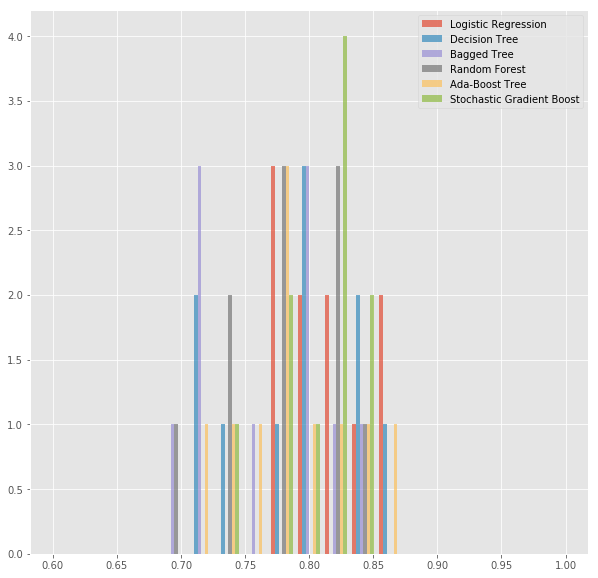

In [33]:
# now plot the results


plt.figure(figsize=(10,10))
plt.hist(all_results,bins=np.linspace(0.6,1,20),alpha=0.7,label=["Logistic Regression","Decision Tree","Bagged Tree","Random Forest","Ada-Boost Tree","Stochastic Gradient Boost"])
plt.legend(loc="upper right")
plt.show()


In [34]:

### NEURAL NETWORK ###
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation

nn = Sequential()
nn.add(Dense(12, input_dim=12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(12,activation='relu'))
nn.add(Dense(1,activation='sigmoid'))

adam_opt = keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999, epsilon=None, decay=0.0)

def cross_entr(y_true,y_pred):
    return(keras.losses.binary_crossentropy(y_true,y_pred))

def mean_pred(y_true,y_pred):
    return(np.mean(y_pred))

nn.compile(loss=cross_entr, optimizer=adam_opt, metrics=["mae"])

nn.fit(train[x_bool_complete],train[y],batch_size=200,epochs=5000)

y_pred = nn.predict(train[x_bool_complete])
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
accuracy_score(y_pred,train[y])




Epoch 1/5000
535/535 [==============================] - 0s 530us/step - loss: 0.6955 - mean_absolute_error: 0.5008
Epoch 2/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6914 - mean_absolute_error: 0.4987
Epoch 3/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6878 - mean_absolute_error: 0.4969
Epoch 4/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6846 - mean_absolute_error: 0.4952
Epoch 5/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6817 - mean_absolute_error: 0.4937
Epoch 6/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6791 - mean_absolute_error: 0.4923
Epoch 7/5000
535/535 [==============================] - 0s 12us/step - loss: 0.6763 - mean_absolute_error: 0.4908
Epoch 8/5000
535/535 [==============================] - 0s 10us/step - loss: 0.6736 - mean_absolute_error: 0.4893
Epoch 9/5000
535/535 [==============================] - 0s 11us/step - loss: 0.6709 - m

535/535 [==============================] - 0s 11us/step - loss: 0.4155 - mean_absolute_error: 0.2599
Epoch 73/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4155 - mean_absolute_error: 0.2614
Epoch 74/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4150 - mean_absolute_error: 0.2620
Epoch 75/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4145 - mean_absolute_error: 0.2610
Epoch 76/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4144 - mean_absolute_error: 0.2590
Epoch 77/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4143 - mean_absolute_error: 0.2572
Epoch 78/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4142 - mean_absolute_error: 0.2571
Epoch 79/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4137 - mean_absolute_error: 0.2579
Epoch 80/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4133 - mean_ab

Epoch 143/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4068 - mean_absolute_error: 0.2520
Epoch 144/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4067 - mean_absolute_error: 0.2516
Epoch 145/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4066 - mean_absolute_error: 0.2509
Epoch 146/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4067 - mean_absolute_error: 0.2503
Epoch 147/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4068 - mean_absolute_error: 0.2501
Epoch 148/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4065 - mean_absolute_error: 0.2503
Epoch 149/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4065 - mean_absolute_error: 0.2502
Epoch 150/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4065 - mean_absolute_error: 0.2500
Epoch 151/5000
535/535 [==============================] - 0s 11us/step -

535/535 [==============================] - 0s 12us/step - loss: 0.4032 - mean_absolute_error: 0.2500
Epoch 214/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4033 - mean_absolute_error: 0.2510
Epoch 215/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4034 - mean_absolute_error: 0.2512
Epoch 216/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4032 - mean_absolute_error: 0.2505
Epoch 217/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4030 - mean_absolute_error: 0.2500
Epoch 218/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4032 - mean_absolute_error: 0.2492
Epoch 219/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4037 - mean_absolute_error: 0.2479
Epoch 220/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4031 - mean_absolute_error: 0.2485
Epoch 221/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4030 -

535/535 [==============================] - 0s 10us/step - loss: 0.4010 - mean_absolute_error: 0.2451
Epoch 284/5000
535/535 [==============================] - 0s 12us/step - loss: 0.4007 - mean_absolute_error: 0.2465
Epoch 285/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4002 - mean_absolute_error: 0.2481
Epoch 286/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4004 - mean_absolute_error: 0.2485
Epoch 287/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4003 - mean_absolute_error: 0.2485
Epoch 288/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4000 - mean_absolute_error: 0.2482
Epoch 289/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4005 - mean_absolute_error: 0.2466
Epoch 290/5000
535/535 [==============================] - 0s 10us/step - loss: 0.4003 - mean_absolute_error: 0.2461
Epoch 291/5000
535/535 [==============================] - 0s 11us/step - loss: 0.4001 -

535/535 [==============================] - 0s 12us/step - loss: 0.3975 - mean_absolute_error: 0.2474
Epoch 354/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3972 - mean_absolute_error: 0.2469
Epoch 355/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3972 - mean_absolute_error: 0.2458
Epoch 356/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3971 - mean_absolute_error: 0.2455
Epoch 357/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3970 - mean_absolute_error: 0.2450
Epoch 358/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3971 - mean_absolute_error: 0.2446
Epoch 359/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3970 - mean_absolute_error: 0.2449
Epoch 360/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3968 - mean_absolute_error: 0.2460
Epoch 361/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3970 -

535/535 [==============================] - 0s 11us/step - loss: 0.3946 - mean_absolute_error: 0.2446
Epoch 424/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3944 - mean_absolute_error: 0.2449
Epoch 425/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3945 - mean_absolute_error: 0.2437
Epoch 426/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3941 - mean_absolute_error: 0.2435
Epoch 427/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3940 - mean_absolute_error: 0.2446
Epoch 428/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3944 - mean_absolute_error: 0.2450
Epoch 429/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3940 - mean_absolute_error: 0.2442
Epoch 430/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3943 - mean_absolute_error: 0.2435
Epoch 431/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3940 -

535/535 [==============================] - 0s 12us/step - loss: 0.3909 - mean_absolute_error: 0.2414
Epoch 494/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3907 - mean_absolute_error: 0.2432
Epoch 495/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3910 - mean_absolute_error: 0.2447
Epoch 496/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3909 - mean_absolute_error: 0.2435
Epoch 497/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3911 - mean_absolute_error: 0.2427
Epoch 498/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3910 - mean_absolute_error: 0.2413
Epoch 499/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3908 - mean_absolute_error: 0.2414
Epoch 500/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3905 - mean_absolute_error: 0.2428
Epoch 501/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3905 -

535/535 [==============================] - 0s 10us/step - loss: 0.3863 - mean_absolute_error: 0.2401
Epoch 564/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3862 - mean_absolute_error: 0.2405
Epoch 565/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3860 - mean_absolute_error: 0.2406
Epoch 566/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3862 - mean_absolute_error: 0.2395
Epoch 567/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3863 - mean_absolute_error: 0.2381
Epoch 568/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3859 - mean_absolute_error: 0.2395
Epoch 569/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3858 - mean_absolute_error: 0.2421
Epoch 570/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3857 - mean_absolute_error: 0.2425
Epoch 571/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3862 -

535/535 [==============================] - 0s 11us/step - loss: 0.3802 - mean_absolute_error: 0.2374
Epoch 634/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3807 - mean_absolute_error: 0.2345
Epoch 635/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3799 - mean_absolute_error: 0.2364
Epoch 636/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3802 - mean_absolute_error: 0.2393
Epoch 637/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3807 - mean_absolute_error: 0.2402
Epoch 638/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3798 - mean_absolute_error: 0.2370
Epoch 639/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3805 - mean_absolute_error: 0.2344
Epoch 640/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3798 - mean_absolute_error: 0.2347
Epoch 641/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3817 -

535/535 [==============================] - 0s 11us/step - loss: 0.3744 - mean_absolute_error: 0.2372
Epoch 704/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3731 - mean_absolute_error: 0.2357
Epoch 705/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3728 - mean_absolute_error: 0.2298
Epoch 706/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3739 - mean_absolute_error: 0.2278
Epoch 707/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3726 - mean_absolute_error: 0.2335
Epoch 708/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3735 - mean_absolute_error: 0.2387
Epoch 709/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3723 - mean_absolute_error: 0.2374
Epoch 710/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3714 - mean_absolute_error: 0.2317
Epoch 711/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3754 -

535/535 [==============================] - 0s 11us/step - loss: 0.3699 - mean_absolute_error: 0.2305
Epoch 774/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3667 - mean_absolute_error: 0.2297
Epoch 775/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3663 - mean_absolute_error: 0.2286
Epoch 776/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3660 - mean_absolute_error: 0.2303
Epoch 777/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3664 - mean_absolute_error: 0.2307
Epoch 778/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3659 - mean_absolute_error: 0.2309
Epoch 779/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3652 - mean_absolute_error: 0.2306
Epoch 780/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3653 - mean_absolute_error: 0.2285
Epoch 781/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3659 - 

535/535 [==============================] - 0s 12us/step - loss: 0.3617 - mean_absolute_error: 0.2237
Epoch 844/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3608 - mean_absolute_error: 0.2314
Epoch 845/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3632 - mean_absolute_error: 0.2331
Epoch 846/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3613 - mean_absolute_error: 0.2270
Epoch 847/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3605 - mean_absolute_error: 0.2250
Epoch 848/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3602 - mean_absolute_error: 0.2288
Epoch 849/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3608 - mean_absolute_error: 0.2305
Epoch 850/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3605 - mean_absolute_error: 0.2303
Epoch 851/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3620 -

535/535 [==============================] - 0s 10us/step - loss: 0.3578 - mean_absolute_error: 0.2303
Epoch 914/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3572 - mean_absolute_error: 0.2316
Epoch 915/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3555 - mean_absolute_error: 0.2219
Epoch 916/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3594 - mean_absolute_error: 0.2231
Epoch 917/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3557 - mean_absolute_error: 0.2252
Epoch 918/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3559 - mean_absolute_error: 0.2234
Epoch 919/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3555 - mean_absolute_error: 0.2231
Epoch 920/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3559 - mean_absolute_error: 0.2252
Epoch 921/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3566 - 

535/535 [==============================] - 0s 11us/step - loss: 0.3538 - mean_absolute_error: 0.2195
Epoch 984/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3524 - mean_absolute_error: 0.2204
Epoch 985/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3517 - mean_absolute_error: 0.2255
Epoch 986/5000
535/535 [==============================] - ETA: 0s - loss: 0.3216 - mean_absolute_error: 0.208 - 0s 11us/step - loss: 0.3517 - mean_absolute_error: 0.2252
Epoch 987/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3516 - mean_absolute_error: 0.2241
Epoch 988/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3516 - mean_absolute_error: 0.2225
Epoch 989/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3515 - mean_absolute_error: 0.2216
Epoch 990/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3515 - mean_absolute_error: 0.2238
Epoch 991/5000
535/535 [=========

535/535 [==============================] - 0s 11us/step - loss: 0.3535 - mean_absolute_error: 0.2297
Epoch 1053/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3489 - mean_absolute_error: 0.2260
Epoch 1054/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3496 - mean_absolute_error: 0.2148
Epoch 1055/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3510 - mean_absolute_error: 0.2167
Epoch 1056/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3487 - mean_absolute_error: 0.2237
Epoch 1057/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3488 - mean_absolute_error: 0.2252
Epoch 1058/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3498 - mean_absolute_error: 0.2202
Epoch 1059/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3478 - mean_absolute_error: 0.2184
Epoch 1060/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3447 - mean_absolute_error: 0.2196
Epoch 1123/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3448 - mean_absolute_error: 0.2181
Epoch 1124/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3440 - mean_absolute_error: 0.2192
Epoch 1125/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3444 - mean_absolute_error: 0.2200
Epoch 1126/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3443 - mean_absolute_error: 0.2200
Epoch 1127/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3445 - mean_absolute_error: 0.2202
Epoch 1128/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3439 - mean_absolute_error: 0.2165
Epoch 1129/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3451 - mean_absolute_error: 0.2143
Epoch 1130/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3421 - mean_absolute_error: 0.2175
Epoch 1193/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3413 - mean_absolute_error: 0.2167
Epoch 1194/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3417 - mean_absolute_error: 0.2150
Epoch 1195/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3415 - mean_absolute_error: 0.2190
Epoch 1196/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3466 - mean_absolute_error: 0.2279
Epoch 1197/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3405 - mean_absolute_error: 0.2143
Epoch 1198/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3461 - mean_absolute_error: 0.2093
Epoch 1199/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3435 - mean_absolute_error: 0.2185
Epoch 1200/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3429 - mean_absolute_error: 0.2111
Epoch 1263/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3403 - mean_absolute_error: 0.2186
Epoch 1264/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3406 - mean_absolute_error: 0.2230
Epoch 1265/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3403 - mean_absolute_error: 0.2087
Epoch 1266/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3437 - mean_absolute_error: 0.2136
Epoch 1267/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3376 - mean_absolute_error: 0.2183
Epoch 1268/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3397 - mean_absolute_error: 0.2134
Epoch 1269/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3398 - mean_absolute_error: 0.2140
Epoch 1270/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3360 - mean_absolute_error: 0.2161
Epoch 1333/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3360 - mean_absolute_error: 0.2072
Epoch 1334/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3344 - mean_absolute_error: 0.2090
Epoch 1335/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3361 - mean_absolute_error: 0.2168
Epoch 1336/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3348 - mean_absolute_error: 0.2161
Epoch 1337/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3354 - mean_absolute_error: 0.2128
Epoch 1338/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3343 - mean_absolute_error: 0.2111
Epoch 1339/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3363 - mean_absolute_error: 0.2143
Epoch 1340/5000
535/535 [==============================] - 0s 10us/step - loss: 0

535/535 [==============================] - 0s 12us/step - loss: 0.3328 - mean_absolute_error: 0.2130
Epoch 1403/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3329 - mean_absolute_error: 0.2130
Epoch 1404/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3330 - mean_absolute_error: 0.2109
Epoch 1405/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3315 - mean_absolute_error: 0.2118
Epoch 1406/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3330 - mean_absolute_error: 0.2140
Epoch 1407/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3333 - mean_absolute_error: 0.2119
Epoch 1408/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3321 - mean_absolute_error: 0.2132
Epoch 1409/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3324 - mean_absolute_error: 0.2168
Epoch 1410/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3349 - mean_absolute_error: 0.2126
Epoch 1473/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3304 - mean_absolute_error: 0.2119
Epoch 1474/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3321 - mean_absolute_error: 0.2033
Epoch 1475/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3312 - mean_absolute_error: 0.2102
Epoch 1476/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3333 - mean_absolute_error: 0.2134
Epoch 1477/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3300 - mean_absolute_error: 0.2113
Epoch 1478/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3327 - mean_absolute_error: 0.2167
Epoch 1479/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3313 - mean_absolute_error: 0.2083
Epoch 1480/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3329 - mean_absolute_error: 0.2198
Epoch 1543/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3298 - mean_absolute_error: 0.2067
Epoch 1544/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3279 - mean_absolute_error: 0.2063
Epoch 1545/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3298 - mean_absolute_error: 0.2154
Epoch 1546/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3281 - mean_absolute_error: 0.2119
Epoch 1547/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3287 - mean_absolute_error: 0.2090
Epoch 1548/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3284 - mean_absolute_error: 0.2049
Epoch 1549/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3292 - mean_absolute_error: 0.2111
Epoch 1550/5000
535/535 [==============================] - 0s 11us/step - loss: 0

535/535 [==============================] - 0s 10us/step - loss: 0.3274 - mean_absolute_error: 0.2092
Epoch 1613/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3270 - mean_absolute_error: 0.2072
Epoch 1614/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3262 - mean_absolute_error: 0.2096
Epoch 1615/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3253 - mean_absolute_error: 0.2056
Epoch 1616/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3260 - mean_absolute_error: 0.2078
Epoch 1617/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3258 - mean_absolute_error: 0.2124
Epoch 1618/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3257 - mean_absolute_error: 0.2063
Epoch 1619/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3267 - mean_absolute_error: 0.2038
Epoch 1620/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3267 - mean_absolute_error: 0.2075
Epoch 1683/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3262 - mean_absolute_error: 0.2100
Epoch 1684/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3263 - mean_absolute_error: 0.2138
Epoch 1685/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3275 - mean_absolute_error: 0.2017
Epoch 1686/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3272 - mean_absolute_error: 0.2071
Epoch 1687/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3246 - mean_absolute_error: 0.2107
Epoch 1688/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3247 - mean_absolute_error: 0.2043
Epoch 1689/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3263 - mean_absolute_error: 0.2047
Epoch 1690/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.3296 - mean_absolute_error: 0.2034
Epoch 1753/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3218 - mean_absolute_error: 0.2069
Epoch 1754/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3223 - mean_absolute_error: 0.2055
Epoch 1755/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3233 - mean_absolute_error: 0.2073
Epoch 1756/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3224 - mean_absolute_error: 0.2072
Epoch 1757/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3265 - mean_absolute_error: 0.2010
Epoch 1758/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3230 - mean_absolute_error: 0.2083
Epoch 1759/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3253 - mean_absolute_error: 0.2104
Epoch 1760/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3206 - mean_absolute_error: 0.2075
Epoch 1823/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3270 - mean_absolute_error: 0.2172
Epoch 1824/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3306 - mean_absolute_error: 0.1992
Epoch 1825/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3240 - mean_absolute_error: 0.1967
Epoch 1826/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3284 - mean_absolute_error: 0.2193
Epoch 1827/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3218 - mean_absolute_error: 0.2100
Epoch 1828/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3258 - mean_absolute_error: 0.1969
Epoch 1829/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3245 - mean_absolute_error: 0.2084
Epoch 1830/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3191 - mean_absolute_error: 0.2030
Epoch 1892/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3213 - mean_absolute_error: 0.2087
Epoch 1893/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3177 - mean_absolute_error: 0.2052
Epoch 1894/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3217 - mean_absolute_error: 0.2002
Epoch 1895/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3191 - mean_absolute_error: 0.2060
Epoch 1896/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3184 - mean_absolute_error: 0.2078
Epoch 1897/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3185 - mean_absolute_error: 0.2011
Epoch 1898/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3198 - mean_absolute_error: 0.2020
Epoch 1899/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3191 - mean_absolute_error: 0.1984
Epoch 1962/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3254 - mean_absolute_error: 0.2162
Epoch 1963/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3184 - mean_absolute_error: 0.2031
Epoch 1964/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3278 - mean_absolute_error: 0.1923
Epoch 1965/5000
535/535 [==============================] - ETA: 0s - loss: 0.3426 - mean_absolute_error: 0.215 - 0s 12us/step - loss: 0.3203 - mean_absolute_error: 0.2077
Epoch 1966/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3213 - mean_absolute_error: 0.2138
Epoch 1967/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3261 - mean_absolute_error: 0.1975
Epoch 1968/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3202 - mean_absolute_error: 0.2032
Epoch 1969/5000
535/535 [=

535/535 [==============================] - 0s 11us/step - loss: 0.3164 - mean_absolute_error: 0.2010
Epoch 2031/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3160 - mean_absolute_error: 0.2003
Epoch 2032/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3153 - mean_absolute_error: 0.2039
Epoch 2033/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3164 - mean_absolute_error: 0.2077
Epoch 2034/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3167 - mean_absolute_error: 0.2026
Epoch 2035/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3183 - mean_absolute_error: 0.1989
Epoch 2036/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3169 - mean_absolute_error: 0.2054
Epoch 2037/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3173 - mean_absolute_error: 0.2080
Epoch 2038/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3176 - mean_absolute_error: 0.2071
Epoch 2101/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3188 - mean_absolute_error: 0.2069
Epoch 2102/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3172 - mean_absolute_error: 0.1975
Epoch 2103/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3178 - mean_absolute_error: 0.2059
Epoch 2104/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3134 - mean_absolute_error: 0.2040
Epoch 2105/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3189 - mean_absolute_error: 0.1939
Epoch 2106/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3170 - mean_absolute_error: 0.2031
Epoch 2107/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3150 - mean_absolute_error: 0.2086
Epoch 2108/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.3131 - mean_absolute_error: 0.2026
Epoch 2171/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3141 - mean_absolute_error: 0.1970
Epoch 2172/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3122 - mean_absolute_error: 0.2035
Epoch 2173/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3138 - mean_absolute_error: 0.2035
Epoch 2174/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3142 - mean_absolute_error: 0.1958
Epoch 2175/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3127 - mean_absolute_error: 0.2010
Epoch 2176/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3139 - mean_absolute_error: 0.2052
Epoch 2177/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3146 - mean_absolute_error: 0.2004
Epoch 2178/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3113 - mean_absolute_error: 0.1959
Epoch 2241/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3128 - mean_absolute_error: 0.2013
Epoch 2242/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3122 - mean_absolute_error: 0.2074
Epoch 2243/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3119 - mean_absolute_error: 0.1984
Epoch 2244/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3139 - mean_absolute_error: 0.1949
Epoch 2245/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3140 - mean_absolute_error: 0.2065
Epoch 2246/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3094 - mean_absolute_error: 0.2025
Epoch 2247/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3127 - mean_absolute_error: 0.1928
Epoch 2248/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3105 - mean_absolute_error: 0.2014
Epoch 2310/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3105 - mean_absolute_error: 0.1963
Epoch 2311/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3082 - mean_absolute_error: 0.1990
Epoch 2312/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3145 - mean_absolute_error: 0.2091
Epoch 2313/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3149 - mean_absolute_error: 0.1933
Epoch 2314/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3125 - mean_absolute_error: 0.1950
Epoch 2315/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3142 - mean_absolute_error: 0.2101
Epoch 2316/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3144 - mean_absolute_error: 0.1926
Epoch 2317/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3081 - mean_absolute_error: 0.1941
Epoch 2379/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3085 - mean_absolute_error: 0.1935
Epoch 2380/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3102 - mean_absolute_error: 0.2046
Epoch 2381/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3097 - mean_absolute_error: 0.2016
Epoch 2382/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3099 - mean_absolute_error: 0.1937
Epoch 2383/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3110 - mean_absolute_error: 0.2053
Epoch 2384/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3099 - mean_absolute_error: 0.2037
Epoch 2385/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3105 - mean_absolute_error: 0.1943
Epoch 2386/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3067 - mean_absolute_error: 0.1952
Epoch 2449/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3064 - mean_absolute_error: 0.1981
Epoch 2450/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3086 - mean_absolute_error: 0.1977
Epoch 2451/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3071 - mean_absolute_error: 0.1956
Epoch 2452/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3052 - mean_absolute_error: 0.1988
Epoch 2453/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3055 - mean_absolute_error: 0.1951
Epoch 2454/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3056 - mean_absolute_error: 0.1971
Epoch 2455/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3104 - mean_absolute_error: 0.2055
Epoch 2456/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.3042 - mean_absolute_error: 0.1938
Epoch 2519/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3064 - mean_absolute_error: 0.1985
Epoch 2520/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3041 - mean_absolute_error: 0.2018
Epoch 2521/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3098 - mean_absolute_error: 0.1870
Epoch 2522/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3158 - mean_absolute_error: 0.2017
Epoch 2523/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3152 - mean_absolute_error: 0.1984
Epoch 2524/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3065 - mean_absolute_error: 0.1959
Epoch 2525/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3089 - mean_absolute_error: 0.2066
Epoch 2526/5000
535/535 [==============================] - 0s 9us/step - loss: 0

535/535 [==============================] - 0s 11us/step - loss: 0.3032 - mean_absolute_error: 0.1975
Epoch 2589/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3030 - mean_absolute_error: 0.1933
Epoch 2590/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3008 - mean_absolute_error: 0.1953
Epoch 2591/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3069 - mean_absolute_error: 0.2030
Epoch 2592/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3044 - mean_absolute_error: 0.1903
Epoch 2593/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3038 - mean_absolute_error: 0.1946
Epoch 2594/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3073 - mean_absolute_error: 0.2020
Epoch 2595/5000
535/535 [==============================] - 0s 9us/step - loss: 0.3053 - mean_absolute_error: 0.1933
Epoch 2596/5000
535/535 [==============================] - 0s 11us/step - loss: 0

535/535 [==============================] - 0s 10us/step - loss: 0.3031 - mean_absolute_error: 0.1937
Epoch 2659/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3023 - mean_absolute_error: 0.1968
Epoch 2660/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3018 - mean_absolute_error: 0.1961
Epoch 2661/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3049 - mean_absolute_error: 0.1911
Epoch 2662/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3061 - mean_absolute_error: 0.1965
Epoch 2663/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3013 - mean_absolute_error: 0.1960
Epoch 2664/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3018 - mean_absolute_error: 0.1929
Epoch 2665/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3005 - mean_absolute_error: 0.1946
Epoch 2666/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3046 - mean_absolute_error: 0.1891
Epoch 2729/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3008 - mean_absolute_error: 0.1986
Epoch 2730/5000
535/535 [==============================] - 0s 13us/step - loss: 0.3031 - mean_absolute_error: 0.1999
Epoch 2731/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3046 - mean_absolute_error: 0.1841
Epoch 2732/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3034 - mean_absolute_error: 0.1902
Epoch 2733/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3027 - mean_absolute_error: 0.1985
Epoch 2734/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2990 - mean_absolute_error: 0.1919
Epoch 2735/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3036 - mean_absolute_error: 0.1974
Epoch 2736/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2980 - mean_absolute_error: 0.1934
Epoch 2799/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2987 - mean_absolute_error: 0.1993
Epoch 2800/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3015 - mean_absolute_error: 0.1927
Epoch 2801/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2993 - mean_absolute_error: 0.1909
Epoch 2802/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3039 - mean_absolute_error: 0.2009
Epoch 2803/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2982 - mean_absolute_error: 0.1935
Epoch 2804/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3011 - mean_absolute_error: 0.1932
Epoch 2805/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3048 - mean_absolute_error: 0.1908
Epoch 2806/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.3003 - mean_absolute_error: 0.2012
Epoch 2868/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3011 - mean_absolute_error: 0.1875
Epoch 2869/5000
535/535 [==============================] - 0s 12us/step - loss: 0.3019 - mean_absolute_error: 0.1963
Epoch 2870/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3032 - mean_absolute_error: 0.1933
Epoch 2871/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3012 - mean_absolute_error: 0.1880
Epoch 2872/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2984 - mean_absolute_error: 0.1984
Epoch 2873/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2992 - mean_absolute_error: 0.1882
Epoch 2874/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2984 - mean_absolute_error: 0.1874
Epoch 2875/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2985 - mean_absolute_error: 0.1890
Epoch 2937/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2978 - mean_absolute_error: 0.1944
Epoch 2938/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2953 - mean_absolute_error: 0.1901
Epoch 2939/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3018 - mean_absolute_error: 0.1854
Epoch 2940/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2978 - mean_absolute_error: 0.1930
Epoch 2941/5000
535/535 [==============================] - ETA: 0s - loss: 0.3199 - mean_absolute_error: 0.218 - 0s 11us/step - loss: 0.2976 - mean_absolute_error: 0.1997
Epoch 2942/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3007 - mean_absolute_error: 0.1864
Epoch 2943/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3029 - mean_absolute_error: 0.1961
Epoch 2944/5000
535/535 [=

535/535 [==============================] - 0s 11us/step - loss: 0.2957 - mean_absolute_error: 0.1945
Epoch 3006/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2962 - mean_absolute_error: 0.1905
Epoch 3007/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2942 - mean_absolute_error: 0.1847
Epoch 3008/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2992 - mean_absolute_error: 0.2003
Epoch 3009/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2976 - mean_absolute_error: 0.1870
Epoch 3010/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3070 - mean_absolute_error: 0.1948
Epoch 3011/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2945 - mean_absolute_error: 0.1927
Epoch 3012/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3001 - mean_absolute_error: 0.1802
Epoch 3013/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2964 - mean_absolute_error: 0.1969
Epoch 3076/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2932 - mean_absolute_error: 0.1852
Epoch 3077/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2938 - mean_absolute_error: 0.1868
Epoch 3078/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2937 - mean_absolute_error: 0.1912
Epoch 3079/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2927 - mean_absolute_error: 0.1877
Epoch 3080/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2932 - mean_absolute_error: 0.1930
Epoch 3081/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2936 - mean_absolute_error: 0.1950
Epoch 3082/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2979 - mean_absolute_error: 0.1816
Epoch 3083/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2954 - mean_absolute_error: 0.1948
Epoch 3146/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2920 - mean_absolute_error: 0.1900
Epoch 3147/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2975 - mean_absolute_error: 0.1811
Epoch 3148/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3080 - mean_absolute_error: 0.2037
Epoch 3149/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3030 - mean_absolute_error: 0.1874
Epoch 3150/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2996 - mean_absolute_error: 0.1850
Epoch 3151/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2978 - mean_absolute_error: 0.2016
Epoch 3152/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2966 - mean_absolute_error: 0.1834
Epoch 3153/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2959 - mean_absolute_error: 0.1834
Epoch 3215/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2978 - mean_absolute_error: 0.2001
Epoch 3216/5000
535/535 [==============================] - 0s 10us/step - loss: 0.3044 - mean_absolute_error: 0.1835
Epoch 3217/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2984 - mean_absolute_error: 0.1908
Epoch 3218/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3005 - mean_absolute_error: 0.1971
Epoch 3219/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3040 - mean_absolute_error: 0.1782
Epoch 3220/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2894 - mean_absolute_error: 0.1890
Epoch 3221/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2953 - mean_absolute_error: 0.2006
Epoch 3222/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2894 - mean_absolute_error: 0.1868
Epoch 3284/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2886 - mean_absolute_error: 0.1837
Epoch 3285/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2884 - mean_absolute_error: 0.1872
Epoch 3286/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2886 - mean_absolute_error: 0.1864
Epoch 3287/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2939 - mean_absolute_error: 0.1890
Epoch 3288/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2907 - mean_absolute_error: 0.1843
Epoch 3289/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2904 - mean_absolute_error: 0.1879
Epoch 3290/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2899 - mean_absolute_error: 0.1885
Epoch 3291/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2888 - mean_absolute_error: 0.1868
Epoch 3354/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2937 - mean_absolute_error: 0.1863
Epoch 3355/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2882 - mean_absolute_error: 0.1869
Epoch 3356/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2908 - mean_absolute_error: 0.1871
Epoch 3357/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2898 - mean_absolute_error: 0.1886
Epoch 3358/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2883 - mean_absolute_error: 0.1870
Epoch 3359/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2952 - mean_absolute_error: 0.1816
Epoch 3360/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2901 - mean_absolute_error: 0.1896
Epoch 3361/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2951 - mean_absolute_error: 0.1807
Epoch 3423/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2916 - mean_absolute_error: 0.1875
Epoch 3424/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2938 - mean_absolute_error: 0.2012
Epoch 3425/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2930 - mean_absolute_error: 0.1815
Epoch 3426/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2946 - mean_absolute_error: 0.1824
Epoch 3427/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2944 - mean_absolute_error: 0.1889
Epoch 3428/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2902 - mean_absolute_error: 0.1821
Epoch 3429/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2913 - mean_absolute_error: 0.1896
Epoch 3430/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2871 - mean_absolute_error: 0.1867
Epoch 3493/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2859 - mean_absolute_error: 0.1869
Epoch 3494/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2893 - mean_absolute_error: 0.1790
Epoch 3495/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2854 - mean_absolute_error: 0.1846
Epoch 3496/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2867 - mean_absolute_error: 0.1890
Epoch 3497/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2861 - mean_absolute_error: 0.1835
Epoch 3498/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2892 - mean_absolute_error: 0.1859
Epoch 3499/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2899 - mean_absolute_error: 0.1853
Epoch 3500/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2865 - mean_absolute_error: 0.1833
Epoch 3563/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2890 - mean_absolute_error: 0.1875
Epoch 3564/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2846 - mean_absolute_error: 0.1850
Epoch 3565/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2845 - mean_absolute_error: 0.1791
Epoch 3566/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2833 - mean_absolute_error: 0.1817
Epoch 3567/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2841 - mean_absolute_error: 0.1854
Epoch 3568/5000
535/535 [==============================] - ETA: 0s - loss: 0.3102 - mean_absolute_error: 0.188 - 0s 12us/step - loss: 0.2841 - mean_absolute_error: 0.1788
Epoch 3569/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2851 - mean_absolute_error: 0.1830
Epoch 3570/5000
535/535 [=

535/535 [==============================] - 0s 12us/step - loss: 0.2861 - mean_absolute_error: 0.1784
Epoch 3632/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2859 - mean_absolute_error: 0.1865
Epoch 3633/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2847 - mean_absolute_error: 0.1779
Epoch 3634/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2844 - mean_absolute_error: 0.1851
Epoch 3635/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2841 - mean_absolute_error: 0.1883
Epoch 3636/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2844 - mean_absolute_error: 0.1781
Epoch 3637/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2838 - mean_absolute_error: 0.1807
Epoch 3638/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2861 - mean_absolute_error: 0.1801
Epoch 3639/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2823 - mean_absolute_error: 0.1851
Epoch 3702/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2845 - mean_absolute_error: 0.1814
Epoch 3703/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2839 - mean_absolute_error: 0.1839
Epoch 3704/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2841 - mean_absolute_error: 0.1792
Epoch 3705/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2869 - mean_absolute_error: 0.1840
Epoch 3706/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2823 - mean_absolute_error: 0.1857
Epoch 3707/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2848 - mean_absolute_error: 0.1770
Epoch 3708/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2851 - mean_absolute_error: 0.1803
Epoch 3709/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2830 - mean_absolute_error: 0.1864
Epoch 3772/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2819 - mean_absolute_error: 0.1820
Epoch 3773/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2824 - mean_absolute_error: 0.1775
Epoch 3774/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2829 - mean_absolute_error: 0.1867
Epoch 3775/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2893 - mean_absolute_error: 0.1780
Epoch 3776/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2864 - mean_absolute_error: 0.1838
Epoch 3777/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2828 - mean_absolute_error: 0.1835
Epoch 3778/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2878 - mean_absolute_error: 0.1770
Epoch 3779/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2844 - mean_absolute_error: 0.1824
Epoch 3842/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2850 - mean_absolute_error: 0.1815
Epoch 3843/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2865 - mean_absolute_error: 0.1906
Epoch 3844/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2848 - mean_absolute_error: 0.1803
Epoch 3845/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2836 - mean_absolute_error: 0.1799
Epoch 3846/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2842 - mean_absolute_error: 0.1847
Epoch 3847/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2820 - mean_absolute_error: 0.1794
Epoch 3848/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2856 - mean_absolute_error: 0.1916
Epoch 3849/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2822 - mean_absolute_error: 0.1789
Epoch 3911/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2829 - mean_absolute_error: 0.1800
Epoch 3912/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2829 - mean_absolute_error: 0.1796
Epoch 3913/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2795 - mean_absolute_error: 0.1787
Epoch 3914/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2832 - mean_absolute_error: 0.1860
Epoch 3915/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2825 - mean_absolute_error: 0.1769
Epoch 3916/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2836 - mean_absolute_error: 0.1793
Epoch 3917/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2819 - mean_absolute_error: 0.1806
Epoch 3918/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2830 - mean_absolute_error: 0.1780
Epoch 3981/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2867 - mean_absolute_error: 0.1859
Epoch 3982/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2815 - mean_absolute_error: 0.1821
Epoch 3983/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2818 - mean_absolute_error: 0.1752
Epoch 3984/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2839 - mean_absolute_error: 0.1835
Epoch 3985/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2802 - mean_absolute_error: 0.1841
Epoch 3986/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2805 - mean_absolute_error: 0.1759
Epoch 3987/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2816 - mean_absolute_error: 0.1854
Epoch 3988/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2802 - mean_absolute_error: 0.1767
Epoch 4051/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2864 - mean_absolute_error: 0.1903
Epoch 4052/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2767 - mean_absolute_error: 0.1747
Epoch 4053/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2780 - mean_absolute_error: 0.1722
Epoch 4054/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2853 - mean_absolute_error: 0.1873
Epoch 4055/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2787 - mean_absolute_error: 0.1773
Epoch 4056/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2796 - mean_absolute_error: 0.1830
Epoch 4057/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2798 - mean_absolute_error: 0.1802
Epoch 4058/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2878 - mean_absolute_error: 0.1738
Epoch 4120/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2811 - mean_absolute_error: 0.1814
Epoch 4121/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2824 - mean_absolute_error: 0.1862
Epoch 4122/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2866 - mean_absolute_error: 0.1690
Epoch 4123/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2811 - mean_absolute_error: 0.1863
Epoch 4124/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2789 - mean_absolute_error: 0.1849
Epoch 4125/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2834 - mean_absolute_error: 0.1740
Epoch 4126/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2775 - mean_absolute_error: 0.1780
Epoch 4127/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2794 - mean_absolute_error: 0.1738
Epoch 4190/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2780 - mean_absolute_error: 0.1807
Epoch 4191/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2796 - mean_absolute_error: 0.1838
Epoch 4192/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2782 - mean_absolute_error: 0.1724
Epoch 4193/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2799 - mean_absolute_error: 0.1757
Epoch 4194/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2777 - mean_absolute_error: 0.1821
Epoch 4195/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2775 - mean_absolute_error: 0.1820
Epoch 4196/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2800 - mean_absolute_error: 0.1737
Epoch 4197/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2775 - mean_absolute_error: 0.1750
Epoch 4260/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2761 - mean_absolute_error: 0.1778
Epoch 4261/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2771 - mean_absolute_error: 0.1827
Epoch 4262/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2775 - mean_absolute_error: 0.1780
Epoch 4263/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2747 - mean_absolute_error: 0.1763
Epoch 4264/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2770 - mean_absolute_error: 0.1800
Epoch 4265/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2735 - mean_absolute_error: 0.1756
Epoch 4266/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2761 - mean_absolute_error: 0.1803
Epoch 4267/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2772 - mean_absolute_error: 0.1790
Epoch 4329/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2786 - mean_absolute_error: 0.1747
Epoch 4330/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2939 - mean_absolute_error: 0.1938
Epoch 4331/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2886 - mean_absolute_error: 0.1681
Epoch 4332/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2782 - mean_absolute_error: 0.1739
Epoch 4333/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2955 - mean_absolute_error: 0.2036
Epoch 4334/5000
535/535 [==============================] - 0s 11us/step - loss: 0.3104 - mean_absolute_error: 0.1694
Epoch 4335/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2871 - mean_absolute_error: 0.1858
Epoch 4336/5000
535/535 [==============================] - 0s 10us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2752 - mean_absolute_error: 0.1802
Epoch 4399/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2764 - mean_absolute_error: 0.1744
Epoch 4400/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2730 - mean_absolute_error: 0.1760
Epoch 4401/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2755 - mean_absolute_error: 0.1781
Epoch 4402/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2728 - mean_absolute_error: 0.1755
Epoch 4403/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2746 - mean_absolute_error: 0.1767
Epoch 4404/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2762 - mean_absolute_error: 0.1761
Epoch 4405/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2752 - mean_absolute_error: 0.1778
Epoch 4406/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2826 - mean_absolute_error: 0.1727
Epoch 4468/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2759 - mean_absolute_error: 0.1807
Epoch 4469/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2808 - mean_absolute_error: 0.1793
Epoch 4470/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2798 - mean_absolute_error: 0.1727
Epoch 4471/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2787 - mean_absolute_error: 0.1845
Epoch 4472/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2767 - mean_absolute_error: 0.1733
Epoch 4473/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2788 - mean_absolute_error: 0.1726
Epoch 4474/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2805 - mean_absolute_error: 0.1879
Epoch 4475/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 10us/step - loss: 0.2870 - mean_absolute_error: 0.1802
Epoch 4538/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2797 - mean_absolute_error: 0.1752
Epoch 4539/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2810 - mean_absolute_error: 0.1864
Epoch 4540/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2814 - mean_absolute_error: 0.1673
Epoch 4541/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2790 - mean_absolute_error: 0.1785
Epoch 4542/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2792 - mean_absolute_error: 0.1827
Epoch 4543/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2824 - mean_absolute_error: 0.1663
Epoch 4544/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2721 - mean_absolute_error: 0.1786
Epoch 4545/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2743 - mean_absolute_error: 0.1793
Epoch 4608/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2773 - mean_absolute_error: 0.1717
Epoch 4609/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2737 - mean_absolute_error: 0.1735
Epoch 4610/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2754 - mean_absolute_error: 0.1770
Epoch 4611/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2724 - mean_absolute_error: 0.1745
Epoch 4612/5000
535/535 [==============================] - 0s 13us/step - loss: 0.2758 - mean_absolute_error: 0.1818
Epoch 4613/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2719 - mean_absolute_error: 0.1722
Epoch 4614/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2741 - mean_absolute_error: 0.1748
Epoch 4615/5000
535/535 [==============================] - 0s 11us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2805 - mean_absolute_error: 0.1646
Epoch 4677/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2850 - mean_absolute_error: 0.1874
Epoch 4678/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2741 - mean_absolute_error: 0.1762
Epoch 4679/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2780 - mean_absolute_error: 0.1732
Epoch 4680/5000
535/535 [==============================] - ETA: 0s - loss: 0.3072 - mean_absolute_error: 0.203 - 0s 12us/step - loss: 0.2747 - mean_absolute_error: 0.1790
Epoch 4681/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2741 - mean_absolute_error: 0.1720
Epoch 4682/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2764 - mean_absolute_error: 0.1816
Epoch 4683/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2767 - mean_absolute_error: 0.1738
Epoch 4684/5000
535/535 [=

535/535 [==============================] - 0s 11us/step - loss: 0.2924 - mean_absolute_error: 0.1634
Epoch 4746/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2756 - mean_absolute_error: 0.1805
Epoch 4747/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2747 - mean_absolute_error: 0.1812
Epoch 4748/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2737 - mean_absolute_error: 0.1707
Epoch 4749/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2784 - mean_absolute_error: 0.1789
Epoch 4750/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2770 - mean_absolute_error: 0.1721
Epoch 4751/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2834 - mean_absolute_error: 0.1870
Epoch 4752/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2743 - mean_absolute_error: 0.1714
Epoch 4753/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 12us/step - loss: 0.2776 - mean_absolute_error: 0.1772
Epoch 4816/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2757 - mean_absolute_error: 0.1804
Epoch 4817/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2800 - mean_absolute_error: 0.1689
Epoch 4818/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2745 - mean_absolute_error: 0.1800
Epoch 4819/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2714 - mean_absolute_error: 0.1761
Epoch 4820/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2718 - mean_absolute_error: 0.1711
Epoch 4821/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2746 - mean_absolute_error: 0.1771
Epoch 4822/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2798 - mean_absolute_error: 0.1745
Epoch 4823/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2708 - mean_absolute_error: 0.1748
Epoch 4885/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2715 - mean_absolute_error: 0.1777
Epoch 4886/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2734 - mean_absolute_error: 0.1690
Epoch 4887/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2749 - mean_absolute_error: 0.1758
Epoch 4888/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2713 - mean_absolute_error: 0.1738
Epoch 4889/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2756 - mean_absolute_error: 0.1754
Epoch 4890/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2726 - mean_absolute_error: 0.1754
Epoch 4891/5000
535/535 [==============================] - 0s 12us/step - loss: 0.2726 - mean_absolute_error: 0.1758
Epoch 4892/5000
535/535 [==============================] - 0s 12us/step - loss: 

535/535 [==============================] - 0s 11us/step - loss: 0.2766 - mean_absolute_error: 0.1773
Epoch 4955/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2728 - mean_absolute_error: 0.1725
Epoch 4956/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2796 - mean_absolute_error: 0.1785
Epoch 4957/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2724 - mean_absolute_error: 0.1722
Epoch 4958/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2690 - mean_absolute_error: 0.1722
Epoch 4959/5000
535/535 [==============================] - 0s 10us/step - loss: 0.2736 - mean_absolute_error: 0.1806
Epoch 4960/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2827 - mean_absolute_error: 0.1679
Epoch 4961/5000
535/535 [==============================] - 0s 11us/step - loss: 0.2768 - mean_absolute_error: 0.1823
Epoch 4962/5000
535/535 [==============================] - 0s 11us/step - loss: 

0.8897196261682243

In [35]:
#def displayAPR(test,x,y):
    #dt.fit(train[x_bool_complete],train[y])

#print("Result of Decision Tree classifier: ",dt_results.mean())

#train_dt_predict = dt.predict(train[x_bool_complete])
#test_dt_predict = dt.predict(test[x_bool_complete])
num_trees = 100
max_features = 5


train_data = train[x_bool_complete]
train_labels = np.array(train[y]).astype(int).ravel()

test_data = test[x_bool_complete]
test_labels = np.array(test[y]).astype(int).ravel()

# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_data,train_labels)
log_pred = logreg.predict(test_data)

dt = tree.DecisionTreeClassifier()
dt.fit(train_data,train_labels)
dt_pred = dt.predict(test_data)

dt2 = tree.DecisionTreeClassifier()
bag_model = BaggingClassifier(base_estimator=dt2,n_estimators=num_trees)
bag_model.fit(train_data,train_labels)
bag_pred = bag_model.predict(test_data)

rf_model = RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
rf_model.fit(train_data,train_labels)
rf_pred = rf_model.predict(test_data)

ada_boost_model = AdaBoostClassifier(n_estimators=num_trees)
ada_boost_model.fit(train_data,train_labels)
ada_pred = ada_boost_model.predict(test_data)

grad_boost_model = GradientBoostingClassifier(n_estimators=num_trees)
grad_boost_model.fit(train_data,train_labels)
grad_pred = grad_boost_model.predict(test_data)

nn_pred = nn.predict(test_data)
nn_pred = [1 if x > 0.5 else 0 for x in nn_pred]

print("Logistic Regression Performance")
print("Accuracy: ",accuracy_score(log_pred,test_labels))
print("Precision: ",precision_score(log_pred,test_labels))
print("Recall: ",recall_score(log_pred,test_labels))
print("F1 score: ",f1_score(log_pred,test_labels))

print("\n")

print("Decision Tree Performance")
print("Accuracy: ",accuracy_score(dt_pred,test_labels))
print("Precision: ",precision_score(dt_pred,test_labels))
print("Recall: ",recall_score(dt_pred,test_labels))
print("F1 score: ",f1_score(dt_pred,test_labels))

print("\n")

print("Bagged Tree Performance")
print("Accuracy: ",accuracy_score(bag_pred,test_labels))
print("Precision: ",precision_score(bag_pred,test_labels))
print("Recall: ",recall_score(bag_pred,test_labels))
print("F1 score: ",f1_score(bag_pred,test_labels))

print("\n")

print("Random Forest Performance")
print("Accuracy: ",accuracy_score(rf_pred,test_labels))
print("Precision: ",precision_score(rf_pred,test_labels))
print("Recall: ",recall_score(rf_pred,test_labels))
print("F1 score: ",f1_score(rf_pred,test_labels))

print("\n")

print("Ada-Boost Tree Performance")
print("Accuracy: ",accuracy_score(ada_pred,test_labels))
print("Precision: ",precision_score(ada_pred,test_labels))
print("Recall: ",recall_score(ada_pred,test_labels))
print("F1 score: ",f1_score(ada_pred,test_labels))

print("\n")

print("Stochastic-Gradient-Boost Tree Performance")
print("Accuracy: ",accuracy_score(grad_pred,test_labels))
print("Precision: ",precision_score(grad_pred,test_labels))
print("Recall: ",recall_score(grad_pred,test_labels))
print("F1 score: ",f1_score(grad_pred,test_labels))

print("\n")

print("Neural Network Performance")
print("Accuracy: ",accuracy_score(nn_pred,test_labels))
print("Precision: ",precision_score(nn_pred,test_labels))
print("Recall: ",recall_score(nn_pred,test_labels))
print("F1 score: ",f1_score(nn_pred,test_labels))


Logistic Regression Performance
('Accuracy: ', 0.8089887640449438)
('Precision: ', 0.6621621621621622)
('Recall: ', 0.8448275862068966)
('F1 score: ', 0.7424242424242424)


Decision Tree Performance
('Accuracy: ', 0.8174157303370787)
('Precision: ', 0.7162162162162162)
('Recall: ', 0.8217054263565892)
('F1 score: ', 0.7653429602888085)


Bagged Tree Performance
('Accuracy: ', 0.851123595505618)
('Precision: ', 0.7432432432432432)
('Recall: ', 0.88)
('F1 score: ', 0.8058608058608058)


Random Forest Performance
('Accuracy: ', 0.8455056179775281)
('Precision: ', 0.7094594594594594)
('Recall: ', 0.8974358974358975)
('F1 score: ', 0.7924528301886792)


Ada-Boost Tree Performance
('Accuracy: ', 0.8174157303370787)
('Precision: ', 0.7094594594594594)
('Recall: ', 0.8267716535433071)
('F1 score: ', 0.7636363636363634)


Stochastic-Gradient-Boost Tree Performance
('Accuracy: ', 0.8398876404494382)
('Precision: ', 0.6959459459459459)
('Recall: ', 0.8956521739130435)
('F1 score: ', 0.78326996197

In [36]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

In [37]:
logreg = LogisticRegression()
logreg.fit(train[x_bool_complete],train[y])

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
print("Coef:", "\t\t\t", "Score:")
for i in range(len(x_bool_complete)):
    print(x_bool_complete[i], "\t\t\t", logreg.coef_[0][i])

('Coef:', '\t\t\t', 'Score:')
('1', '\t\t\t', 1.1175873288166773)
('2', '\t\t\t', 0.2210302436567746)
('3', '\t\t\t', -1.0690173656180744)
('Q', '\t\t\t', 0.3890465671515048)
('S', '\t\t\t', -0.3698281168208467)
('C', '\t\t\t', 0.014782040123668927)
('Age', '\t\t\t', -1.0562984407286624)
('male', '\t\t\t', -1.0376227894578172)
('female', '\t\t\t', 1.3072229963132094)
('IsKid', '\t\t\t', 1.3291576406156436)
('Alone', '\t\t\t', -0.039101616433812776)
('Fare', '\t\t\t', 0.15240206977960552)


In [ ]:
# base Decision Tree

dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# bagged Tree

dotfile = open("bagged_dt.dot", 'w')
tree.export_graphviz(rf_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Random Forrest

dotfile = open("random_f.dot", 'w')
tree.export_graphviz(bagged_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Ada Boost

dotfile = open("ada_boost.dot", 'w')
tree.export_graphviz(ada_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

# Stochastic Gradient Boost

dotfile = open("sg_boost.dot", 'w')
tree.export_graphviz(gradient_boost_model, out_file=dotfile, feature_names=dt_x)
dotfile.close()

In [39]:
test_predictions = [log_pred,dt_pred,bag_pred,rf_pred,ada_pred,grad_pred,nn_pred]
print("Confusion matricies")
print("Logistic Regression")
print(confusion_matrix(log_pred,test_labels))

print("Decision Tree")
print(confusion_matrix(dt_pred,test_labels))

print("Bagged Tree")
print(confusion_matrix(bag_pred,test_labels))

print("Random Forest")
print(confusion_matrix(rf_pred,test_labels))

print("Ada-Boost")
print(confusion_matrix(ada_pred,test_labels))

print("Stochastic Gradient Boost")
print(confusion_matrix(grad_pred,test_labels))

print("Neural Network")
print(confusion_matrix(nn_pred,test_labels))

Confusion matricies
Logistic Regression
[[190  50]
 [ 18  98]]
Decision Tree
[[185  42]
 [ 23 106]]
Bagged Tree
[[193  38]
 [ 15 110]]
Random Forest
[[196  43]
 [ 12 105]]
Ada-Boost
[[186  43]
 [ 22 105]]
Stochastic Gradient Boost
[[196  45]
 [ 12 103]]
Neural Network
[[184  49]
 [ 24  99]]


In [113]:
# now for the kaggle submission...

kaggle_test = pd.read_csv("./../data/titanic/test.csv")

In [114]:
kdf.tail(50)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Q,S,C,male,female,3,2,1,IsKid,Alone
368,1260,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,0.592105,0,1,112378,0.115941,NaN,...,0,0,1,0,1,0,0,1,0,0
369,1261,2,"Pallas y Castello, Mr. Emilio",male,0.381579,0,0,SC/PARIS 2147,0.027050,NaN,...,0,0,1,1,0,0,1,0,0,1
370,1262,2,"Giles, Mr. Edgar",male,0.276316,1,0,28133,0.022447,NaN,...,0,1,0,1,0,0,1,0,0,0
371,1263,1,"Wilson, Miss. Helen Alice",female,0.407895,0,0,16966,0.262527,E39 E41,...,0,0,1,0,1,0,0,1,0,1
372,1264,1,"Ismay, Mr. Joseph Bruce",male,0.644737,0,0,112058,0.000000,B52 B54 B56,...,0,1,0,1,0,0,0,1,0,1
373,1265,2,"Harbeck, Mr. William H",male,0.578947,0,0,248746,0.025374,NaN,...,0,1,0,1,0,0,1,0,0,1
374,1266,1,"Dodge, Mrs. Washington (Ruth Vidaver)",female,0.710526,1,1,33638,0.159777,A34,...,0,1,0,0,1,0,0,1,0,0
375,1267,1,"Bowen, Miss. Grace Scott",female,0.592105,0,0,PC 17608,0.512122,NaN,...,0,0,1,0,1,0,0,1,0,1
376,1268,3,"Kink, Miss. Maria",female,0.289474,2,0,315152,0.016908,NaN,...,0,1,0,0,1,1,0,0,0,0
377,1269,2,"Cotterill, Mr. Henry Harry""""",male,0.276316,0,0,29107,0.022447,NaN,...,0,1,0,1,0,0,1,0,0,1


In [115]:
kdf = applyTransformations(kaggle_test)

In [116]:
#kdf[x_bool_complete].isna().any()
kdf["Fare"].apply(pd.to_numeric).isin([np.nan]).unique()
kdf["Fare"].isin([np.nan]).unique()

array([False])

In [119]:
# this will create a csv file called "titanic_submission.csv"

def createKaggleSubmission(df,model,x_cols):
    submission = pd.DataFrame()
    submission["PassengerId"] = df["PassengerId"]
    submission["Survived"] = model.predict(df[x_bool_complete])
    submission.to_csv("./titanic_submission.csv",index=False)
    return submission

submission = createKaggleSubmission(kdf,bag_model,x_bool_complete)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
